In [ ]:
# Connect Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
## paths for the dataset
train_path = '/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/train'
test_path = '/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/test'

Classes: ['mites', 'bollworm', 'mosquito', 'armyworm', 'sawfly', 'beetle', 'stem_borer', 'aphids', 'grasshopper']

 Image Distribution per Class:
             Number of Images
mosquito                  295
beetle                    291
grasshopper               277
aphids                    266
mites                     254
bollworm                  245
armyworm                  223
sawfly                    200
stem_borer                181

Total Images in Train Set: 2232


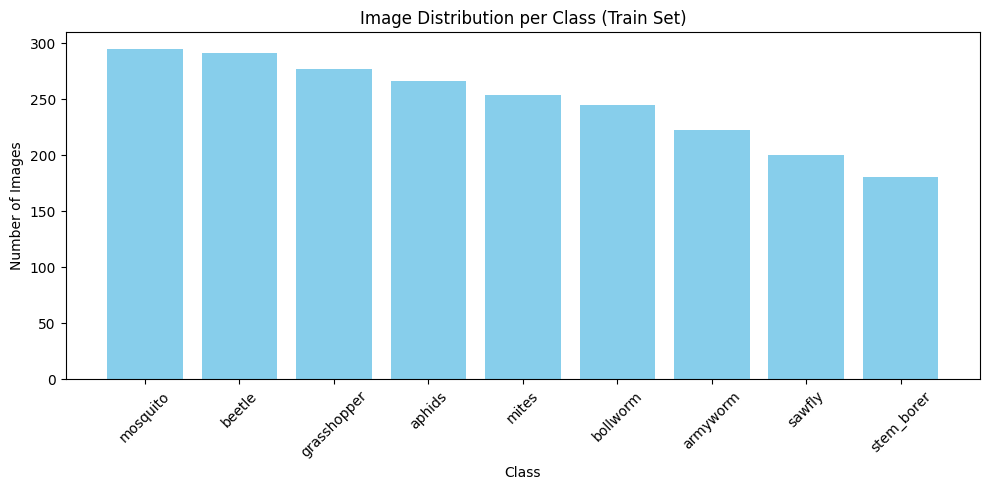

In [ ]:
# List all classes (subfolder names)
classes = os.listdir(train_path)
print("Classes:", classes)

# Count images per class
class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = num_images

# Display as DataFrame
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Number of Images'])
df_counts = df_counts.sort_values(by='Number of Images', ascending=False)

print("\n Image Distribution per Class:")
print(df_counts)

# Total images
total_images = sum(class_counts.values())
print("\nTotal Images in Train Set:", total_images)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(df_counts.index, df_counts['Number of Images'], color='skyblue')
plt.xticks(rotation=45)
plt.title("Image Distribution per Class (Train Set)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [ ]:
def check_and_remove_corrupted_images(dataset_path):
    corrupted_images = []

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except Exception as e:
                corrupted_images.append(image_path)
                print(f"Corrupted image found and removed: {image_path}")
                os.remove(image_path)

    if not corrupted_images:
        print("No corrupted image found.")
    else:
        print(f"\n Total corrupted images removed: {len(corrupted_images)}")

# Run the check
check_and_remove_corrupted_images(train_path)


No corrupted image found.


In [ ]:
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_width, img_height = 128, 128
batch_size = 32

# Training Data Generator (with Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Training Set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation Set
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1788 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Found {test_generator.samples} test images")


Found 384 images belonging to 9 classes.
Found 384 test images


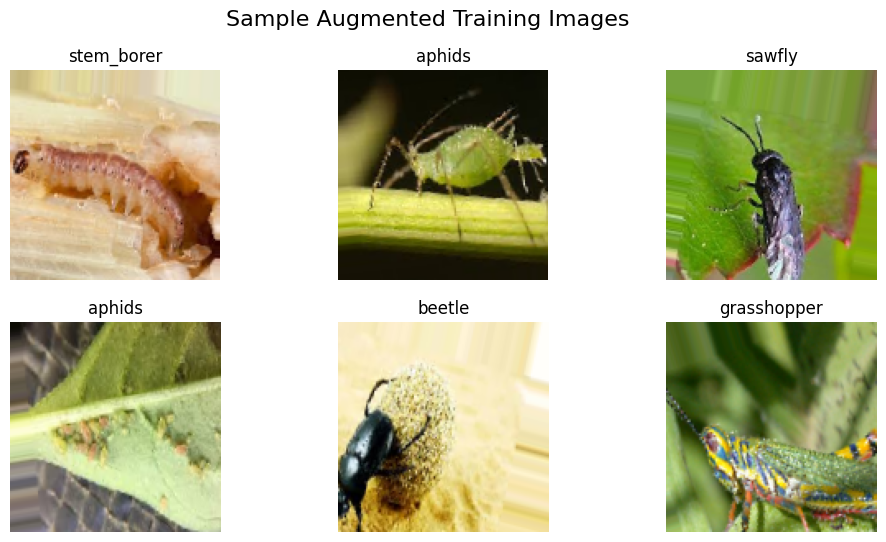

In [ ]:
# Get class names from train_generator
class_indices = train_generator.class_indices
classes = list(class_indices.keys())


# Visualize augmented images
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(classes[np.argmax(sample_labels[i])])
    plt.axis('off')
plt.suptitle("Sample Augmented Training Images", fontsize=16)
plt.show()



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input

model = Sequential([

    Input(shape=(img_width, img_height, 3)),

    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),

    # Output Layer (5 classes)
    Dense(9, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,104,201 (49.99 MB)

 Trainable params: 13,104,201 (49.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
import time

start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
    batch_size=batch_size
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n Training Time: {training_time:.2f} seconds ({training_time/60:.2f}minutes)")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 690ms/step - accuracy: 0.1466 - loss: 2.2371 - val_accuracy: 0.1982 - val_loss: 2.1066
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.2247 - loss: 2.0603 - val_accuracy: 0.2500 - val_loss: 2.0161
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.2690 - loss: 2.0101 - val_accuracy: 0.3243 - val_loss: 1.8568
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.3125 - loss: 1.8784 - val_accuracy: 0.2613 - val_loss: 1.9564
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.3758 - loss: 1.7702 - val_accuracy: 0.3468 - val_loss: 1.8239
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.3747 - loss: 1.6624 - val_accuracy: 0.3626 - val_loss: 1.7594
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.4426 - loss: 1.5116 - val_accuracy: 0.3716 - val_loss: 1.7289
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 339ms/step - accuracy: 0.5206 - loss: 1.3533 - val_accu

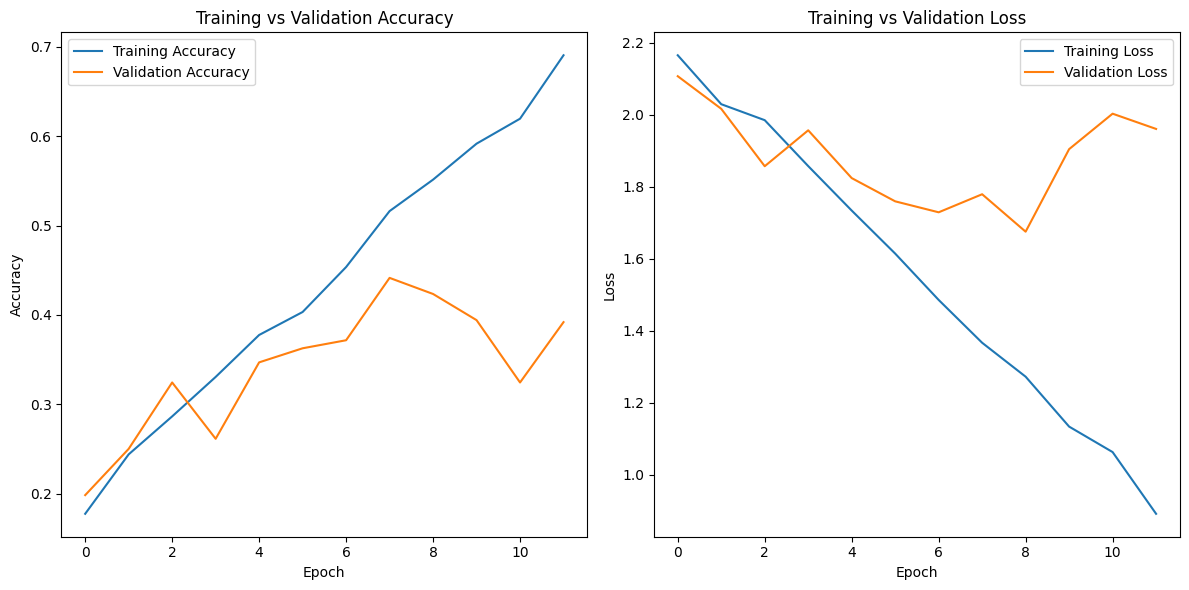

In [ ]:
# Plot the Training vs Validation Loss Curves and Training vs Validation Accuracy Curves

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Print key metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
gap = abs(final_train_acc - final_val_acc)

print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Accuracy Gap: {gap*100:.2f}%")
print(f"Last Loss: {history.history['loss'][-1]:.4f}")
print(f"Last Val Loss: {history.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 69.07%
Final Validation Accuracy: 39.19%
Accuracy Gap: 29.88%
Last Loss: 0.8923
Last Val Loss: 1.9603


In [ ]:
from sklearn.metrics import classification_report


# Get predictions on the validation data
Y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step
Classification Report:
              precision    recall  f1-score   support

      aphids       0.10      0.15      0.12        53
    armyworm       0.09      0.07      0.08        44
      beetle       0.14      0.12      0.13        58
    bollworm       0.11      0.08      0.09        49
 grasshopper       0.07      0.07      0.07        55
       mites       0.11      0.14      0.13        50
    mosquito       0.19      0.15      0.17        59
      sawfly       0.15      0.20      0.17        40
  stem_borer       0.04      0.03      0.03        36

    accuracy                           0.11       444
   macro avg       0.11      0.11      0.11       444
weighted avg       0.11      0.11      0.11       444



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step

Image: jpg_0 - Copy.jpg
True class: aphids
Predicted: aphids (56.5%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Image: jpg_10.jpg
True class: armyworm
Predicted: sawfly (66.5%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Image: jpg_1.jpg
True class: grasshopper
Predicted: mites (44.5%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Image: jpg_0.jpg
True class: mosquito
Predicted: mosquito (99.7%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Image: jpg_0.jpg
True class: sawfly
Predicted: mites (62.7%)


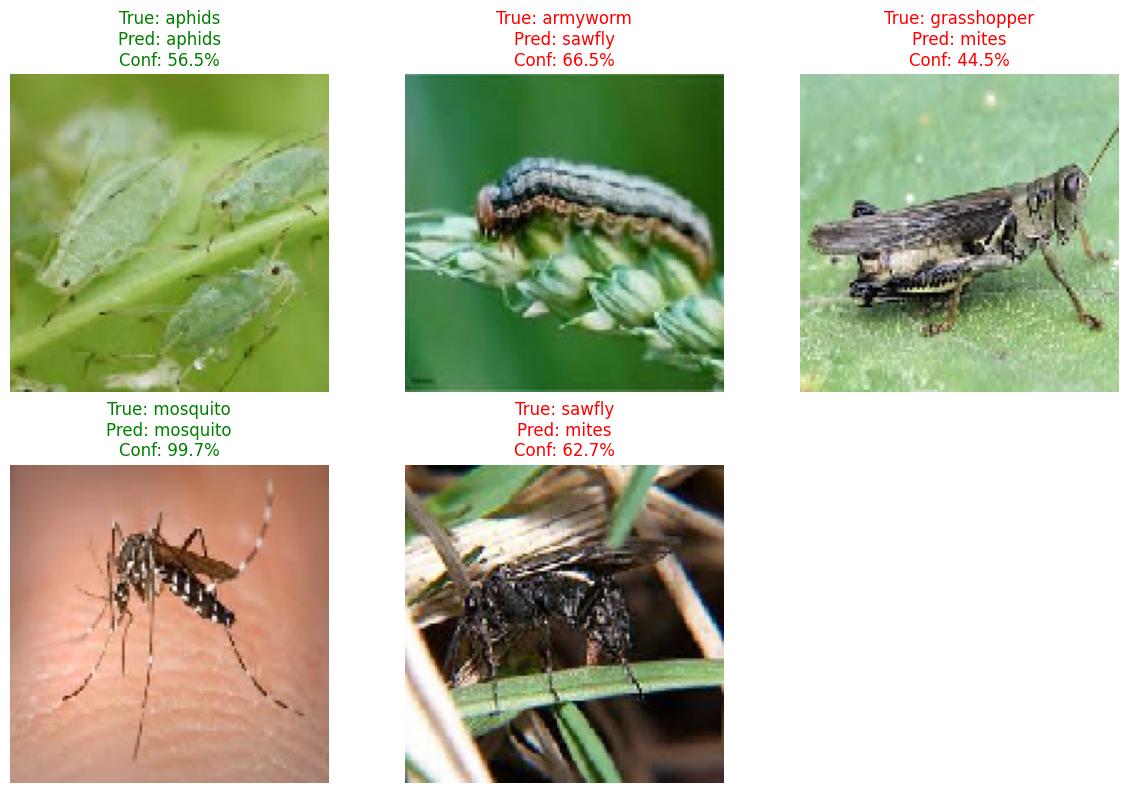

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_and_plot(image_paths, model, classes, img_width, img_height):
    """
    Perform inference on multiple images and plot results with confidence scores
    Args:
        image_paths: List of paths to test images
        model: Trained Keras model
        classes: List of class names
        img_width: Target image width
        img_height: Target image height
    """
    plt.figure(figsize=(12, 8))

    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_array = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

        # Get prediction
        preds = model.predict(img_array)[0]
        pred_class = classes[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Get true class from path
        true_class = img_path.split('/')[-2] if '/' in img_path else "Unknown"

        # Plot the image with the result
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%",
                  color='green' if pred_class == true_class else 'red')
        plt.axis('off')

        # Print prediction details
        print(f"\nImage: {img_path.split('/')[-1]}")
        print(f"True class: {true_class}")
        print(f"Predicted: {pred_class} ({confidence:.1f}%)")

    plt.tight_layout()
    plt.show()

# Example test images
test_samples = [
   "/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/test/aphids/jpg_0 - Copy.jpg",
    "/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/test/armyworm/jpg_10.jpg",
    "/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/test/grasshopper/jpg_1.jpg",
    "/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/test/mosquito/jpg_0.jpg",
    "/content/drive/MyDrive/AI_ML_Sem6/Assesment1/pest/test/sawfly/jpg_0.jpg"
]

# Call the function
predict_and_plot(
    image_paths=test_samples,
    model=model,
    classes=classes,
    img_width=img_width,
    img_height=img_height
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model Architecture
deeper_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

     # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),  # Dropout added after Dense layers
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout added after Dense layers
    Dense(train_generator.num_classes, activation='softmax')
])





/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
deeper_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,199,273 (65.61 MB)

 Trainable params: 17,198,825 (65.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

start_time = time.time()

# Train the model
history_deeper = deeper_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n Training Time: {training_time:.2f} seconds ({training_time/60:.2f}minutes)")



Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 602ms/step - accuracy: 0.1265 - loss: 9.5750 - val_accuracy: 0.1441 - val_loss: 2.3219 - learning_rate: 0.0010
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.1999 - loss: 2.3596 - val_accuracy: 0.0991 - val_loss: 2.3388 - learning_rate: 0.0010
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.1639 - loss: 2.3191 - val_accuracy: 0.1284 - val_loss: 2.3205 - learning_rate: 0.0010
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.2018 - loss: 2.2349 - val_accuracy: 0.2342 - val_loss: 2.2460 - learning_rate: 0.0010
Epoch 5/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.2240 - loss: 2.2334 - val_accuracy: 0.1959 - val_loss: 2.2700 - learning_rate: 0.0010
Epoch 6/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.2089 - loss: 2.1997 - val_accuracy: 0.2477 - val_loss: 2.1944 - learning_rate: 0.0010
Epoch 7/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.2415 - loss: 2.

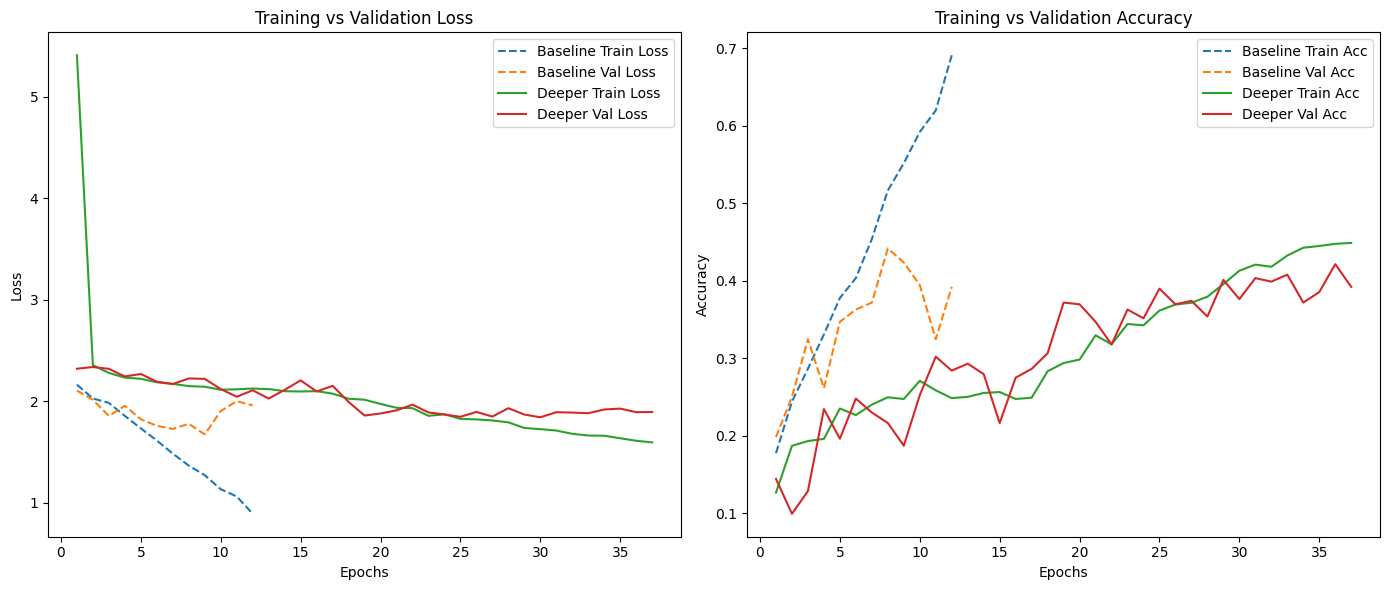

In [ ]:
# Extract metrics for both model
baseline_loss = history.history['loss']
baseline_val_loss = history.history['val_loss']
baseline_acc = history.history['accuracy']
baseline_val_acc = history.history['val_accuracy']

deep_loss = history_deeper.history['loss']
deep_val_loss = history_deeper.history['val_loss']
deep_acc = history_deeper.history['accuracy']
deep_val_acc = history_deeper.history['val_accuracy']


baseline_epochs_range = range(1, len(baseline_loss) + 1)
deep_epochs_range = range(1, len(deep_loss) + 1)


# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(baseline_epochs_range, baseline_loss, label='Baseline Train Loss', linestyle='--')
plt.plot(baseline_epochs_range, baseline_val_loss, label='Baseline Val Loss', linestyle='--')
plt.plot(deep_epochs_range, deep_loss, label='Deeper Train Loss')
plt.plot(deep_epochs_range, deep_val_loss, label='Deeper Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(baseline_epochs_range, baseline_acc, label='Baseline Train Acc', linestyle='--')
plt.plot(baseline_epochs_range, baseline_val_acc, label='Baseline Val Acc', linestyle='--')
plt.plot(deep_epochs_range, deep_acc, label='Deeper Train Acc')
plt.plot(deep_epochs_range, deep_val_acc, label='Deeper Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Accuracy Comparison
print(f"Baseline Val Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"Deeper Model Val Accuracy: {history_deeper.history['val_accuracy'][-1]*100:.2f}%")

# Loss Comparison
print(f"Baseline Val Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Deeper Model Val Loss: {history_deeper.history['val_loss'][-1]:.4f}")



Baseline Val Accuracy: 39.19%
Deeper Model Val Accuracy: 39.19%
Baseline Val Loss: 1.9603
Deeper Model Val Loss: 1.8953


In [ ]:
# For baseline
baseline_preds = model.predict(validation_generator)
baseline_y_pred = np.argmax(baseline_preds, axis=1)
baseline_y_true = validation_generator.classes

# For deeper
deeper_preds = deeper_model.predict(validation_generator)
deeper_y_pred = np.argmax(deeper_preds, axis=1)

# Class names
class_names = list(validation_generator.class_indices.keys())

print("Baseline Model Classification Report:")
print(classification_report(baseline_y_true, baseline_y_pred, target_names=class_names))

print("Deeper Model Classification Report:")
print(classification_report(baseline_y_true, deeper_y_pred, target_names=class_names))


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step
Baseline Model Classification Report:
              precision    recall  f1-score   support

      aphids       0.13      0.21      0.16        53
    armyworm       0.15      0.11      0.13        44
      beetle       0.25      0.24      0.25        58
    bollworm       0.09      0.06      0.07        49
 grasshopper       0.11      0.09      0.10        55
       mites       0.15      0.18      0.17        50
    mosquito       0.13      0.12      0.12        59
      sawfly       0.09      0.12      0.11        40
  stem_borer       0.13      0.11      0.12        36

    accuracy                           0.14       444
   macro avg       0.14      0.14      0.14       444
weighted avg       0.14      0.14      0.14       444

Deeper Model Classification Report:
              precision    recall  f1-score   support

      aphids       0.10      0.34      0.16        53
    armyworm       0.00      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.optimizers import SGD

# Re-create the same model (to reset weights)
def create_model_with_dropout_after_dense(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create a fresh instance of the model
model_sgd = create_model_with_dropout_after_dense((img_width, img_height, 3), train_generator.num_classes)

# Compile with SGD optimizer
model_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (optional but recommended)
early_stop_sgd = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr_sgd = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train
history_sgd = model_sgd.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[early_stop_sgd, reduce_lr_sgd],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 421ms/step - accuracy: 0.1314 - loss: 3.9587 - val_accuracy: 0.1419 - val_loss: 2.6458 - learning_rate: 0.0100
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.1787 - loss: 2.2503 - val_accuracy: 0.1509 - val_loss: 2.3722 - learning_rate: 0.0100
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.2193 - loss: 2.2218 - val_accuracy: 0.2297 - val_loss: 2.2010 - learning_rate: 0.0100
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.2171 - loss: 2.1777 - val_accuracy: 0.2973 - val_loss: 2.1087 - learning_rate: 0.0100
Epoch 5/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.2798 - loss: 2.0923 - val_accuracy: 0.2275 - val_loss: 2.1752 - learning_rate: 0.0100
Epoch 6/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.2752 - loss: 2.0875 - val_accuracy: 0.2905 - val_loss: 2.1434 - learning_rate: 0.0100
Epoch 7/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.3095 - loss: 1.

In [ ]:
print("Adam Optimizer - Best Validation Accuracy:", max(history_deeper.history['val_accuracy']))
print("SGD Optimizer  - Best Validation Accuracy:", max(history_sgd.history['val_accuracy']))

Adam Optimizer - Best Validation Accuracy: 0.4211711585521698
SGD Optimizer  - Best Validation Accuracy: 0.43918919563293457


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained VGG16 (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for feature extraction
transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Summary
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         4,61

 Total params: 14,984,009 (57.16 MB)

 Trainable params: 268,297 (1.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train only the top layers
history_transfer = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 496ms/step - accuracy: 0.1754 - loss: 2.7194 - val_accuracy: 0.2748 - val_loss: 2.0764 - learning_rate: 1.0000e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step - accuracy: 0.2964 - loss: 2.0574 - val_accuracy: 0.3649 - val_loss: 1.9544 - learning_rate: 1.0000e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.4031 - loss: 1.7907 - val_accuracy: 0.4032 - val_loss: 1.8349 - learning_rate: 1.0000e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 363ms/step - accuracy: 0.4928 - loss: 1.5139 - val_accuracy: 0.4617 - val_loss: 1.7022 - learning_rate: 1.0000e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.5193 - loss: 1.4298 - val_accuracy: 0.4820 - val_loss: 1.5975 - learning_rate: 1.0000e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.5287 - loss: 1.3437 - val_accuracy: 0.4842 - val_loss: 1.5298 - learning_rate: 1.0000e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - acc

In [ ]:
val_acc = max(history_transfer.history['val_accuracy']) * 100
print(f"Transfer Learning - Validation Accuracy: {val_acc:.2f}%")

Transfer Learning - Validation Accuracy: 51.80%


In [ ]:
# ====== Fine-Tuning Step ======

for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train again (Fine-Tuning)
history_finetune = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - accuracy: 0.6716 - loss: 0.9557 - val_accuracy: 0.5586 - val_loss: 1.2959 - learning_rate: 1.0000e-05
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.7411 - loss: 0.7656 - val_accuracy: 0.6081 - val_loss: 1.2819 - learning_rate: 1.0000e-05
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - accuracy: 0.7701 - loss: 0.6646 - val_accuracy: 0.5698 - val_loss: 1.3468 - learning_rate: 1.0000e-05
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.8310 - loss: 0.5648 - val_accuracy: 0.5766 - val_loss: 1.3496 - learning_rate: 1.0000e-05
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.8480 - loss: 0.5027 - val_accuracy: 0.5833 - val_loss: 1.2370 - learning_rate: 1.0000e-05
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.8598 - loss: 0.4526 - val_accuracy: 0.6149 - val_loss: 1.2469 - learning_rate: 1.0000e-05
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - acc

In [ ]:
val_acc = max(history_finetune.history['val_accuracy']) * 100
print(f"Fine Tuning  - Validation Accuracy: {val_acc:.2f}%")


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step

Classification Report:

              precision    recall  f1-score   support

      aphids       0.20      0.26      0.23        53
    armyworm       0.12      0.14      0.13        44
      beetle       0.15      0.14      0.14        58
    bollworm       0.09      0.10      0.10        49
 grasshopper       0.14      0.18      0.16        55
       mites       0.15      0.08      0.10        50
    mosquito       0.19      0.24      0.21        59
      sawfly       0.14      0.07      0.10        40
  stem_borer       0.09      0.06      0.07        36

    accuracy                           0.15       444
   macro avg       0.14      0.14      0.14       444
weighted avg       0.14      0.15      0.14       444



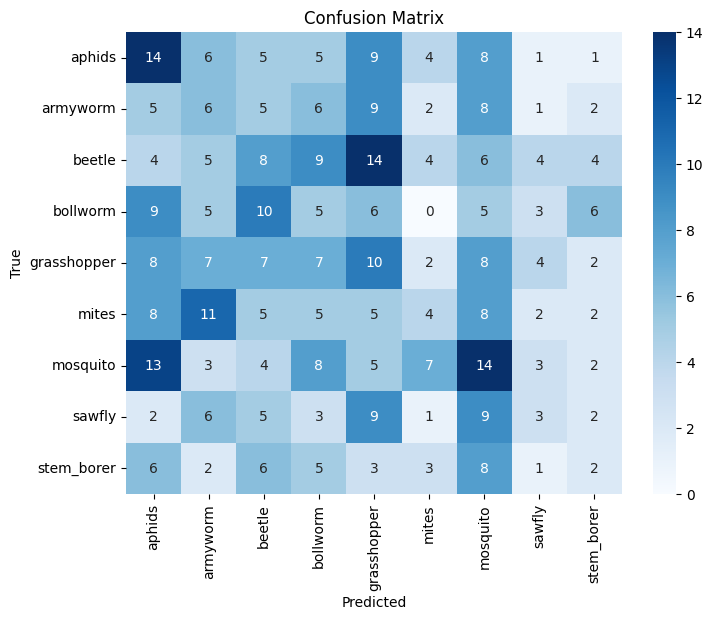

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, generator):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(transfer_model, validation_generator)


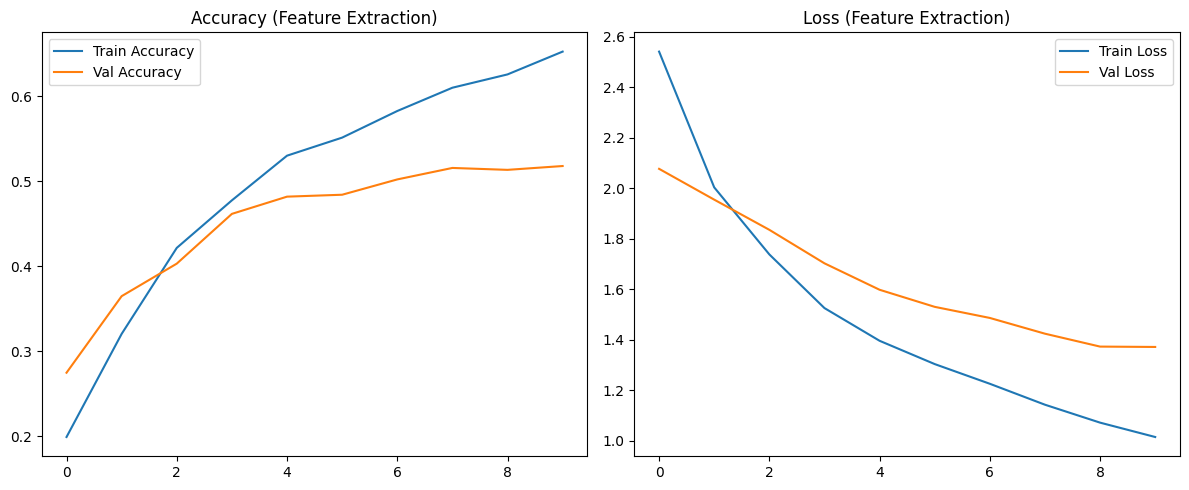

In [ ]:
def plot_training_history(history, title=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy " + title)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss " + title)

    plt.tight_layout()
    plt.show()

plot_training_history(history_transfer, "(Feature Extraction)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


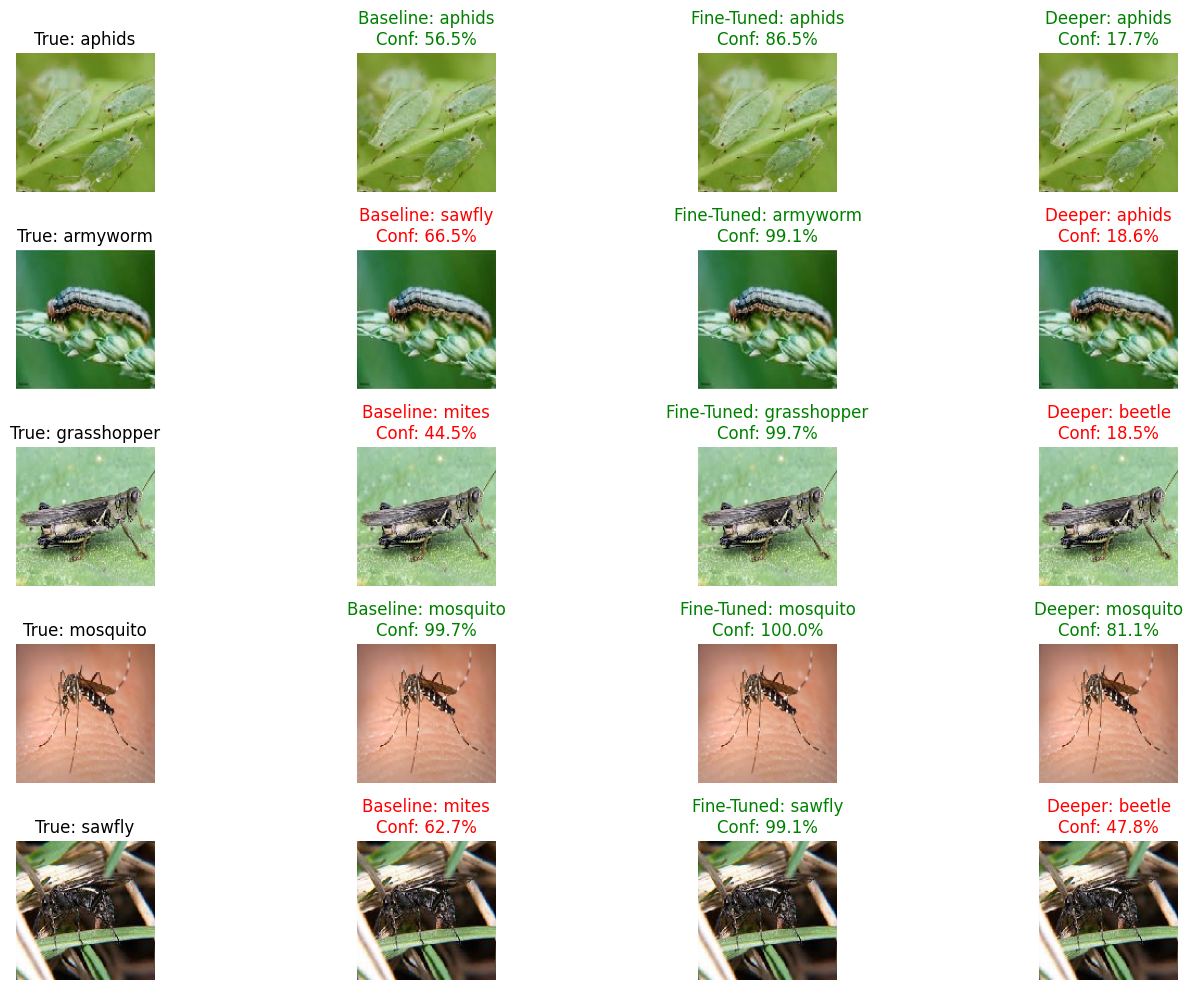

In [ ]:
def predict_and_plot_comparison(image_paths, baseline_model, fine_tuned_model, deeper_model, classes, img_width, img_height):
    """
    Perform inference on multiple images using baseline, fine-tuned, and deeper models and plot the comparison
    Args:
        image_paths: List of paths to test images
        baseline_model: Trained baseline Keras model
        fine_tuned_model: Trained fine-tuned Keras model
        deeper_model: Trained deeper Keras model
        classes: List of class names
        img_width: Target image width
        img_height: Target image height
    """
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_array = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

        # Get predictions from all models
        baseline_preds = baseline_model.predict(img_array)[0]
        fine_tuned_preds = fine_tuned_model.predict(img_array)[0]
        deeper_preds = deeper_model.predict(img_array)[0]

        baseline_pred_class = classes[np.argmax(baseline_preds)]
        fine_tuned_pred_class = classes[np.argmax(fine_tuned_preds)]
        deeper_pred_class = classes[np.argmax(deeper_preds)]

        baseline_confidence = np.max(baseline_preds) * 100
        fine_tuned_confidence = np.max(fine_tuned_preds) * 100
        deeper_confidence = np.max(deeper_preds) * 100

        # Get true class from path (assuming structure: .../class_name/image.jpg)
        true_class = img_path.split('/')[-2] if '/' in img_path else "Unknown"

        # Plot the images and predictions
        plt.subplot(len(image_paths), 4, i * 4 + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}")
        plt.axis('off')

        plt.subplot(len(image_paths), 4, i * 4 + 2)
        plt.imshow(img)
        plt.title(f"Baseline: {baseline_pred_class}\nConf: {baseline_confidence:.1f}%", color='green' if baseline_pred_class == true_class else 'red')
        plt.axis('off')

        plt.subplot(len(image_paths), 4, i * 4 + 3)
        plt.imshow(img)
        plt.title(f"Fine-Tuned: {fine_tuned_pred_class}\nConf: {fine_tuned_confidence:.1f}%", color='green' if fine_tuned_pred_class == true_class else 'red')
        plt.axis('off')

        plt.subplot(len(image_paths), 4, i * 4 + 4)
        plt.imshow(img)
        plt.title(f"Deeper: {deeper_pred_class}\nConf: {deeper_confidence:.1f}%", color='green' if deeper_pred_class == true_class else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to compare all models
predict_and_plot_comparison(
    image_paths=test_samples,
    baseline_model=model,            # Baseline model
    fine_tuned_model=transfer_model, # Fine-tuned model
    deeper_model=deeper_model,       # Deeper model
    classes=classes,
    img_width=img_width,
    img_height=img_height
)
